Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [ ]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FILE_PATH = '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/'
ACTORS = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 
          'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 
          'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 
          'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
EMOTIONS = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

In [ ]:
# Load preprocessed data for DNN
fetched_data = np.zeros([11307, 19728])
labels = np.zeros(11307)
data_index = 0

for actor in ACTORS:
  file_path = FILE_PATH + actor + '/'
  print(file_path)
  for dirname, _, files in os.walk(file_path):
    for CURRENT_FILE in files:
      if CURRENT_FILE[21:] != 'face.csv':
        continue
      VIDEO_PATH = os.path.join(dirname, CURRENT_FILE)
      AUDIO_PATH = dirname+CURRENT_FILE[:21]+'audio.csv'

      audio = []
      with open(VIDEO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        video = np.array(data)
        # 4624
      with open(AUDIO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        audio = np.array(data).flatten()
        #15104
      for i in range(video.shape[0]):
        fetched_data[data_index] = np.concatenate([video[i], audio])
        labels[data_index] = np.array(int(CURRENT_FILE[7])-1)
        data_index += 1

/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_01/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_02/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_03/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_04/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_05/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_06/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_07/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_08/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_09/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_10/
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/Actor_11/
/content/drive/MyDrive/CV_Project_Workspace

In [ ]:
print(fetched_data[-1])

[  0.          18.02775638  35.35533906 ... -80.         -80.
 -80.        ]


In [ ]:
import random

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.2 * example_nums)

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:]

print(len(random_train_ids), len(random_test_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids,:])
Y_train = torch.as_tensor(labels[random_train_ids]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids,:])
Y_test = torch.as_tensor(labels[random_test_ids]).type(torch.int64)


9045 2262


In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.features = X

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    feature = self.features[index]
    label = self.labels[index]
    return feature, label

In [ ]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(7)
tensor([6, 6, 1,  ..., 4, 4, 1])


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        features, labels = batch 
        out = self(features.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch
        out = self(features.type(torch.FloatTensor).to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
class LR_Perceptron(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    
    self.fc1_video = torch.nn.Linear(15104, 512)
    self.fc2_video = torch.nn.Linear(512, 512)
    self.fc3_video = torch.nn.Linear(512, 512)
    self.fc4_video = torch.nn.Linear(512, 512)
    self.fc5_video = torch.nn.Linear(512, 512)
    self.fc6_video = torch.nn.Linear(512, 8)

    self.fc1_audio = torch.nn.Linear(4624, 512)
    self.fc2_audio = torch.nn.Linear(512, 512)
    self.fc3_audio = torch.nn.Linear(512, 512)
    self.fc4_audio = torch.nn.Linear(512, 512)
    self.fc5_audio = torch.nn.Linear(512, 512)
    self.fc6_audio = torch.nn.Linear(512, 8)

    self.fc1 = torch.nn.Linear(16, 80)
    self.fc2 = torch.nn.Linear(80, 80)
    self.fc3 = torch.nn.Linear(80, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    a = x[:,:4624]
    v = x[:,4624:]
    v = self.fc1_video(v)
    v = F.relu(v)
    v = self.fc2_video(v)
    v = F.relu(v)
    v = self.fc3_video(v)
    v = F.relu(v)
    v = self.fc4_video(v)
    v = F.relu(v)
    v = self.fc5_video(v)
    v = F.relu(v)
    v = self.fc6_video(v)

    a = self.fc1_audio(a)
    a = F.relu(a)
    a = self.fc2_audio(a)
    a = F.relu(a)
    a = self.fc3_audio(a)
    a = F.relu(a)
    a = self.fc4_audio(a)
    a = F.relu(a)
    a = self.fc5_audio(a)
    a = F.relu(a)
    a = self.fc6_audio(a)
    
    x = self.fc1(torch.cat((v,a), dim=1).to(device))
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
model = LR_Perceptron()
model.to(device)
# train_dataset.labels = train_dataset.labels.to(device)
# train_dataset.faces = train_dataset.faces.to(device)
# test_dataset.labels = test_dataset.labels.to(device)
# test_dataset.faces = test_dataset.faces.to(device)
# validation_dataset.labels = validation_dataset.labels.to(device)
# validation_dataset.faces = validation_dataset.faces.to(device)

LR_Perceptron(
  (fc1_video): Linear(in_features=15104, out_features=512, bias=True)
  (fc2_video): Linear(in_features=512, out_features=512, bias=True)
  (fc3_video): Linear(in_features=512, out_features=512, bias=True)
  (fc4_video): Linear(in_features=512, out_features=512, bias=True)
  (fc5_video): Linear(in_features=512, out_features=512, bias=True)
  (fc6_video): Linear(in_features=512, out_features=8, bias=True)
  (fc1_audio): Linear(in_features=4624, out_features=512, bias=True)
  (fc2_audio): Linear(in_features=512, out_features=512, bias=True)
  (fc3_audio): Linear(in_features=512, out_features=512, bias=True)
  (fc4_audio): Linear(in_features=512, out_features=512, bias=True)
  (fc5_audio): Linear(in_features=512, out_features=512, bias=True)
  (fc6_audio): Linear(in_features=512, out_features=8, bias=True)
  (fc1): Linear(in_features=16, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=8, bi

In [ ]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)

In [ ]:
history = [evaluate(model, test_dataloader)]
history

[{'val_loss': 2.0823047161102295, 'val_acc': 0.14532865583896637}]

In [ ]:
history += fit(20, 0.0001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 1.7995, val_acc: 0.3058
Epoch [1], val_loss: 1.7226, val_acc: 0.3379
Epoch [2], val_loss: 1.6490, val_acc: 0.3503
Epoch [3], val_loss: 1.6847, val_acc: 0.3364
Epoch [4], val_loss: 1.5554, val_acc: 0.3796
Epoch [5], val_loss: 1.5277, val_acc: 0.4112
Epoch [6], val_loss: 1.5199, val_acc: 0.4234
Epoch [7], val_loss: 1.4330, val_acc: 0.4388
Epoch [8], val_loss: 1.5163, val_acc: 0.4345
Epoch [9], val_loss: 1.3930, val_acc: 0.4785
Epoch [10], val_loss: 1.5147, val_acc: 0.4208
Epoch [11], val_loss: 1.3570, val_acc: 0.4774
Epoch [12], val_loss: 1.1881, val_acc: 0.5544
Epoch [13], val_loss: 1.3281, val_acc: 0.4772
Epoch [14], val_loss: 1.0623, val_acc: 0.5939
Epoch [15], val_loss: 0.9483, val_acc: 0.6653
Epoch [16], val_loss: 1.1245, val_acc: 0.5670
Epoch [17], val_loss: 0.7967, val_acc: 0.6948
Epoch [18], val_loss: 0.7173, val_acc: 0.7358
Epoch [19], val_loss: 0.9391, val_acc: 0.6408


In [ ]:
history += fit(20, 0.00001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 0.6808, val_acc: 0.7473
Epoch [1], val_loss: 0.6365, val_acc: 0.7789
Epoch [2], val_loss: 0.6317, val_acc: 0.7720
Epoch [3], val_loss: 0.6129, val_acc: 0.7783
Epoch [4], val_loss: 0.6197, val_acc: 0.7818
Epoch [5], val_loss: 0.6189, val_acc: 0.7740
Epoch [6], val_loss: 0.5886, val_acc: 0.7846
Epoch [7], val_loss: 0.5965, val_acc: 0.7794
Epoch [8], val_loss: 0.5938, val_acc: 0.7777
Epoch [9], val_loss: 0.5642, val_acc: 0.7922
Epoch [10], val_loss: 0.5532, val_acc: 0.7998
Epoch [11], val_loss: 0.5561, val_acc: 0.7939
Epoch [12], val_loss: 0.5611, val_acc: 0.7965
Epoch [13], val_loss: 0.5271, val_acc: 0.8139
Epoch [14], val_loss: 0.5145, val_acc: 0.8108
Epoch [15], val_loss: 0.5190, val_acc: 0.8115
Epoch [16], val_loss: 0.4916, val_acc: 0.8262
Epoch [17], val_loss: 0.4859, val_acc: 0.8217
Epoch [18], val_loss: 0.4914, val_acc: 0.8299
Epoch [19], val_loss: 0.5024, val_acc: 0.8186


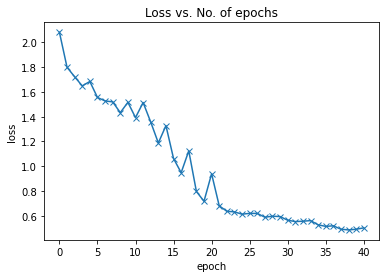

In [ ]:
plot_losses(history)

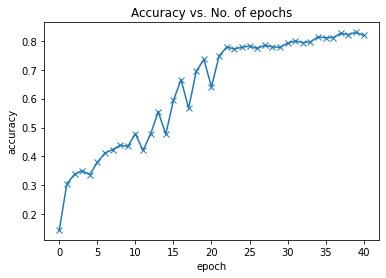

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_dataloader)

{'val_loss': 0.5024367570877075, 'val_acc': 0.818636953830719}

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/emotion_classification-feedforward.pth")